In [1]:
## for data
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.preprocessing import LabelEncoder

## for explainer
from lime import lime_tabular

In [2]:
dtf = pd.read_csv('train.csv')
dtf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#Return a tuple representing the dimensionality of the DataFrame
dtf.shape

(891, 12)

In [4]:
#summary of the dataframe
dtf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
#Missing values
dtf.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
#basic statistic
dtf.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
#check duplicate
dtf.loc[dtf.duplicated()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [8]:
'''
Recognize whether a column is numerical or categorical.
:parameter
    :param dtf: dataframe - input data
    :param col: str - name of the column to analyze
    :param max_cat: num - max number of unique values to recognize a column as categorical
:return
    "cat" if the column is categorical or "num" otherwise
'''
def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

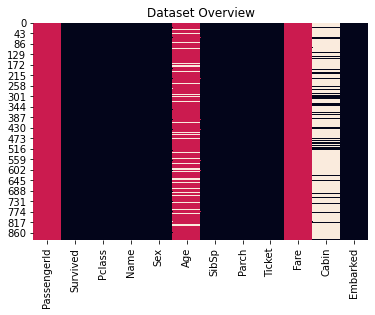

 Categerocial   Numeric   NaN 


In [9]:
dic_cols = {col:utils_recognize_type(dtf, col, max_cat=20) for col in dtf.columns}
heatmap = dtf.isnull()
for k,v in dic_cols.items():
 if v == "num":
   heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
 else:
   heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

Age and Fare are numerical variables while the others are categorical.
Only Age and Cabin contain missing data.

In [10]:
#PassengerId as index or primary key of the table/dataframe
dtf = dtf.set_index("PassengerId")
#Survived is the phenomenon that we want to understand and predict (or target variable).
#1 if the passenger survived and 0 otherwise, therefore this use case is a binary classification problem
dtf = dtf.rename(columns={"Survived":"Y"})

<b>Exploratory Data Analysis</b>

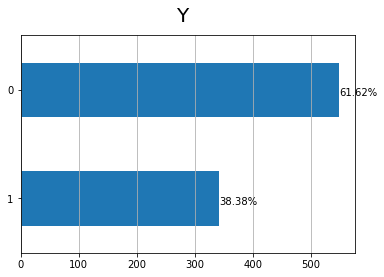

In [11]:
y = "Y"
ax = dtf[y].value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(y, fontsize=20)
plt.show()

In [12]:
# lets check the number of unique items present in the categorical column

dtf.select_dtypes('object').nunique()

Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
dtype: int64

Text(0, 0.5, 'Age')

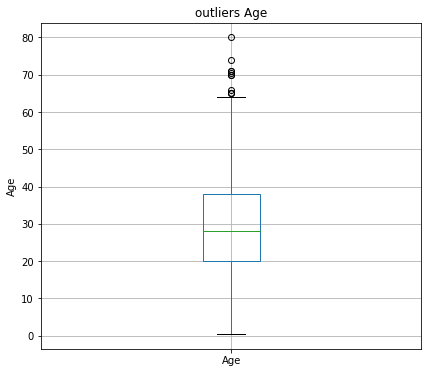

In [13]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = dtf.boxplot(column=['Age'])
fig.set_title('outliers Age')
fig.set_ylabel('Age')

In [14]:
dtf[(dtf['Age']<0) | (dtf['Age']>80)].size

0

Text(0, 0.5, 'Fare')

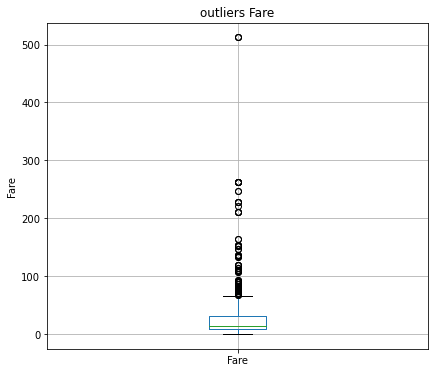

In [15]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = dtf.boxplot(column=['Fare'])
fig.set_title('outliers Fare')
fig.set_ylabel('Fare')

C:\Users\User\Adira\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


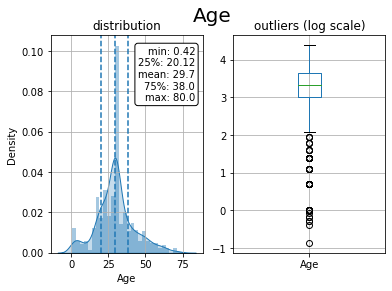

In [16]:
x = "Age"
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)

#a histogram is perfect to give a rough sense of the density of the underlying distribution of a single numerical data
### distribution
ax[0].title.set_text('distribution')
variable = dtf[x].fillna(dtf[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = dtf[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
#using a box plot to graphically depict data groups through their quartiles
### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_dtf = pd.DataFrame(dtf[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1])
plt.show()

<h6>analysis to the next level and look into the bivariate distribution to understand if Age has predictive power to predict Y. This would be the case of categorical (Y) vs numerical (Age)</h6>

C:\Users\User\Adira\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\Adira\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


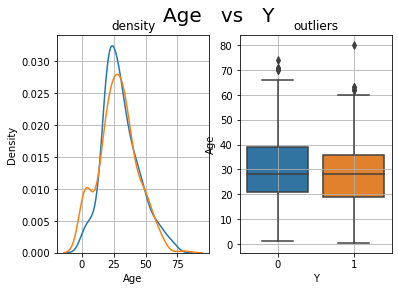

In [17]:
cat, num = "Y", "Age"
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x+"   vs   "+y, fontsize=20)
            
### distribution
ax[0].title.set_text('density')
for i in dtf[cat].unique():
    sns.distplot(dtf[dtf[cat]==i][num], hist=False, label=i, ax=ax[0])
ax[0].grid(True)

### boxplot   
ax[1].title.set_text('outliers')
sns.boxplot(x=cat, y=num, data=dtf, ax=ax[1])
ax[1].grid(True)
plt.show()

In [18]:
#categorical (Y) vs numerical (Age), I would use a one-way ANOVA test. 
#Basically, it tests whether the means of two or more independent samples are significantly different, 
#so if the p-value is small enough (<0.05) the null hypothesis of samples means equality can be rejected

cat, num = "Y", "Age"
model = smf.ols(num+' ~ '+cat, data=dtf).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables are Correlated (p-value: 0.039)


C:\Users\User\Adira\lib\site-packages\seaborn\categorical.py:3772: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try countplot
  warnings.warn(msg, UserWarning)


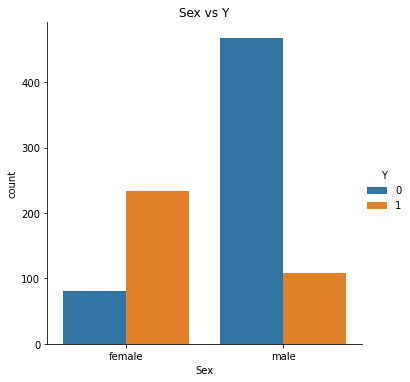

In [19]:
x, y = "Sex", "Y"

### count
order = dtf.groupby(x)[y].count().index.tolist()
sns.catplot(x=x, hue=y, data=dtf, kind='count', order=order, ax=ax)
plt.title('Sex vs Y')

plt.show()

In [20]:
#both categorical, I’d use a Chi-Square test: assuming that two variables are independent (null hypothesis), 
#it tests whether the values of the contingency table for these variables are uniformly distributed. 
#If the p-value is small enough (<0.05), the null hypothesis can be rejected and we can say that the two 
#variables are probably dependent

x, y = "Sex", "Y"
cont_table = pd.crosstab(index=dtf[x], columns=dtf[y])
chi2_test = scipy.stats.chi2_contingency(cont_table)
chi2, p = chi2_test[0], chi2_test[1]
n = cont_table.sum().sum()
phi2 = chi2/n
r,k = cont_table.shape
phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
rcorr = r-((r-1)**2)/(n-1)
kcorr = k-((k-1)**2)/(n-1)
coeff = np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))
coeff, p = round(coeff, 3), round(p, 3)
conclusion = "Significant" if p < 0.05 else "Non-Significant"
print("Cramer Correlation:", coeff, conclusion, "(p-value:"+str(p)+")")

Cramer Correlation: 0.54 Significant (p-value:0.0)


<b>Data Preprocessing</b>

In [21]:
## Create new column
dtf["Cabin_section"] = dtf["Cabin"].apply(lambda x: str(x)[0])
dtf.head()

,Y,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_section
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,n
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,n
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,n


Text(0.5, 1.0, 'Cabin_section vs Pclass (filter: Y)')

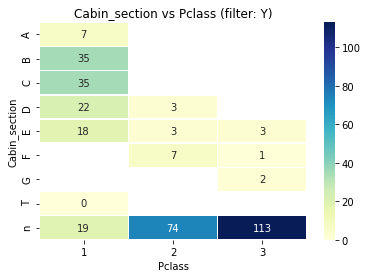

In [22]:
## Plot contingency table
cont_table = pd.crosstab(index=dtf["Cabin_section"], 
             columns=dtf["Pclass"], values=dtf["Y"], aggfunc="sum")
sns.heatmap(cont_table, annot=True, cmap="YlGnBu", fmt='.0f',
            linewidths=.5).set_title( 
            'Cabin_section vs Pclass (filter: Y)' )

In [23]:
dtf.head()

,Y,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_section
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,n
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,n
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,n


In [24]:
#drop col with a lot of missing values
dtf=dtf.drop(columns=['Name','Cabin'])

In [25]:
objList = dtf.select_dtypes(include = "object").columns
print (objList)

Index(['Sex', 'Ticket', 'Embarked', 'Cabin_section'], dtype='object')


In [26]:
#Label Encoding for object to numeric conversion
#from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in objList:
    dtf[feat] = le.fit_transform(dtf[feat].astype(str))

print (dtf.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Y              891 non-null    int64  
 1   Pclass         891 non-null    int64  
 2   Sex            891 non-null    int32  
 3   Age            714 non-null    float64
 4   SibSp          891 non-null    int64  
 5   Parch          891 non-null    int64  
 6   Ticket         891 non-null    int32  
 7   Fare           891 non-null    float64
 8   Embarked       891 non-null    int32  
 9   Cabin_section  891 non-null    int32  
dtypes: float64(2), int32(4), int64(4)
memory usage: 94.9 KB
None


In [27]:
dtf.head()

,Y,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_section
PassengerId,,,,,,,,,,
1,0,3,1,22.0,1,0,523,7.2500,2,8
2,1,1,0,38.0,1,0,596,71.2833,0,2
3,1,3,0,26.0,0,0,669,7.9250,2,8
4,1,1,0,35.0,1,0,49,53.1000,2,2
5,0,3,1,35.0,0,0,472,8.0500,2,8


In [28]:
dtf["Age"] = dtf["Age"].fillna(dtf["Age"].mean())

In [29]:
## split data
dtf_train, dtf_test = model_selection.train_test_split(dtf, 
                      test_size=0.3)

## print info
print("X_train shape:", dtf_train.drop("Y",axis=1).shape, "| X_test shape:", dtf_test.drop("Y",axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train["Y"]),2), "| y_test mean:", round(np.mean(dtf_test["Y"]),2))
print(dtf_train.shape[1], "features:", dtf_train.drop("Y",axis=1).columns.to_list())

X_train shape: (623, 9) | X_test shape: (268, 9)
y_train mean: 0.4 | y_test mean: 0.35
10 features: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked', 'Cabin_section']


In [30]:
## create dummy
dummy = pd.get_dummies(dtf_train["Sex"], prefix="Sex",drop_first=True)
dtf_train= pd.concat([dtf_train, dummy], axis=1)
print( dtf_train.filter(like="Sex", axis=1).head() )
## drop the original categorical column
dtf = dtf_train.drop("Sex", axis=1)

             Sex  Sex_1
PassengerId            
764            0      0
732            1      1
54             0      0
145            1      1
693            1      1


In [31]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(dtf_train.drop("Y", axis=1))
dtf_scaled= pd.DataFrame(X, columns=dtf_train.drop("Y", axis=1).columns, index=dtf_train.index)
dtf_scaled["Y"] = dtf_train["Y"]
dtf_scaled.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_section,Sex_1,Y
PassengerId,,,,,,,,,,,
764,0.0,0.0,0.447097,0.125,0.333333,0.048529,0.234224,0.666667,0.125,0.0,1
732,1.0,1.0,0.132948,0.000,0.000000,0.317647,0.036671,0.000000,1.000,1.0,0
54,0.5,0.0,0.359135,0.125,0.000000,0.351471,0.050749,0.666667,1.000,0.0,1
145,0.5,1.0,0.220910,0.000,0.000000,0.173529,0.022447,0.666667,1.000,1.0,0
693,1.0,1.0,0.367921,0.000,0.000000,0.117647,0.110272,0.666667,1.000,1.0,1


<b>Feature selection</b>

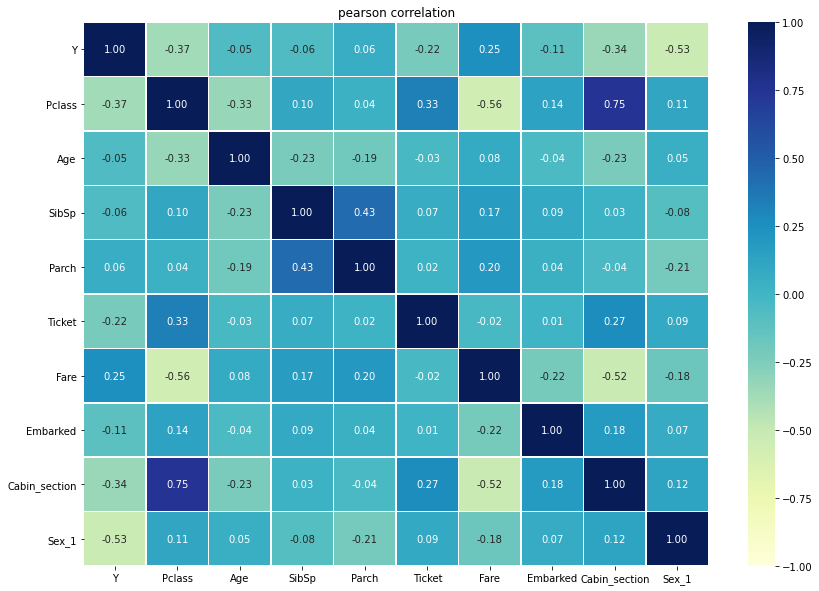

In [32]:
#Feature selection is the process of selecting a subset of relevant variables to build the machine learning model. 
#It makes the model easier to interpret and reduces overfitting (when the model adapts too much to the training data 
#and performs badly outside the train set)

plt.figure(figsize=(14,10))
corr_matrix = dtf.copy()
for col in corr_matrix.columns:
    if corr_matrix[col].dtype == "O":
         corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
corr_matrix = corr_matrix.corr(method="pearson")
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("pearson correlation")
plt.show()

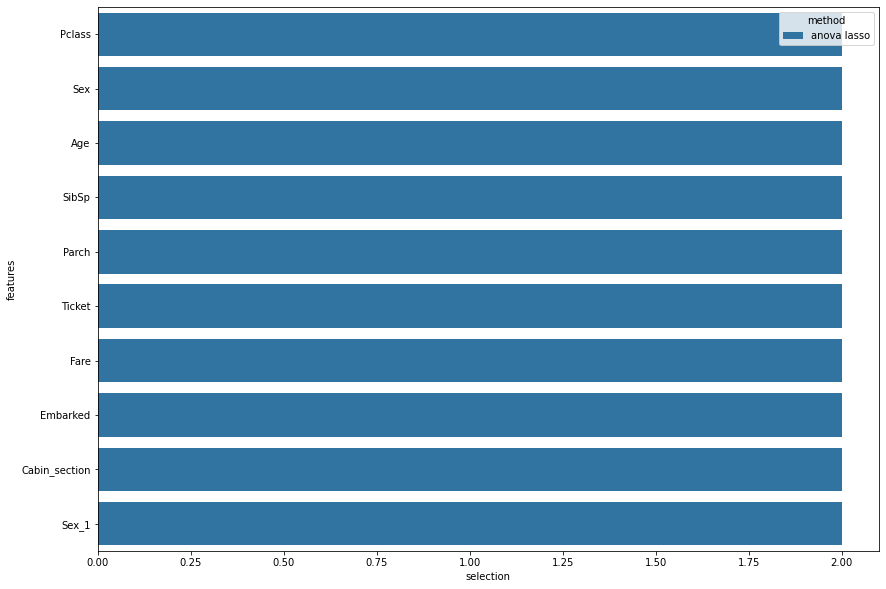

In [33]:
#LASSO regularization is a regression analysis method that performs both variable selection 
#and regularization in order to enhance accuracy and interpretability.

plt.figure(figsize=(14,10))
X = dtf_train.drop("Y", axis=1).values
y = dtf_train["Y"].values
feature_names = dtf_train.drop("Y", axis=1).columns
## Anova
selector = feature_selection.SelectKBest(score_func=  
               feature_selection.f_classif, k=10).fit(X,y)
anova_selected_features = feature_names[selector.get_support()]

## Lasso regularization
selector = feature_selection.SelectFromModel(estimator= 
              linear_model.LogisticRegression(C=1, penalty="l1", 
              solver='liblinear'), max_features=10).fit(X,y)
lasso_selected_features = feature_names[selector.get_support()]
 
## Plot
dtf_features = pd.DataFrame({"features":feature_names})
dtf_features["anova"] = dtf_features["features"].apply(lambda x: "anova" if x in anova_selected_features else "")
dtf_features["num1"] = dtf_features["features"].apply(lambda x: 1 if x in anova_selected_features else 0)
dtf_features["lasso"] = dtf_features["features"].apply(lambda x: "lasso" if x in lasso_selected_features else "")
dtf_features["num2"] = dtf_features["features"].apply(lambda x: 1 if x in lasso_selected_features else 0)
dtf_features["method"] = dtf_features[["anova","lasso"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]
sns.barplot(y="features", x="selection", hue="method", data=dtf_features.sort_values("selection", ascending=False), dodge=False)

plt.show()

The blue features are the ones selected by both ANOVA and LASSO, the others are selected by just one of the two methods

In [34]:
dtf_train.head()

,Y,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_section,Sex_1
PassengerId,,,,,,,,,,,
764,1,1,0,36.000000,1,2,33,120.0000,2,1,0
732,0,3,1,11.000000,0,0,216,18.7875,0,8,1
54,1,2,0,29.000000,1,0,239,26.0000,2,8,0
145,0,2,1,18.000000,0,0,118,11.5000,2,8,1
693,1,3,1,29.699118,0,0,80,56.4958,2,8,1


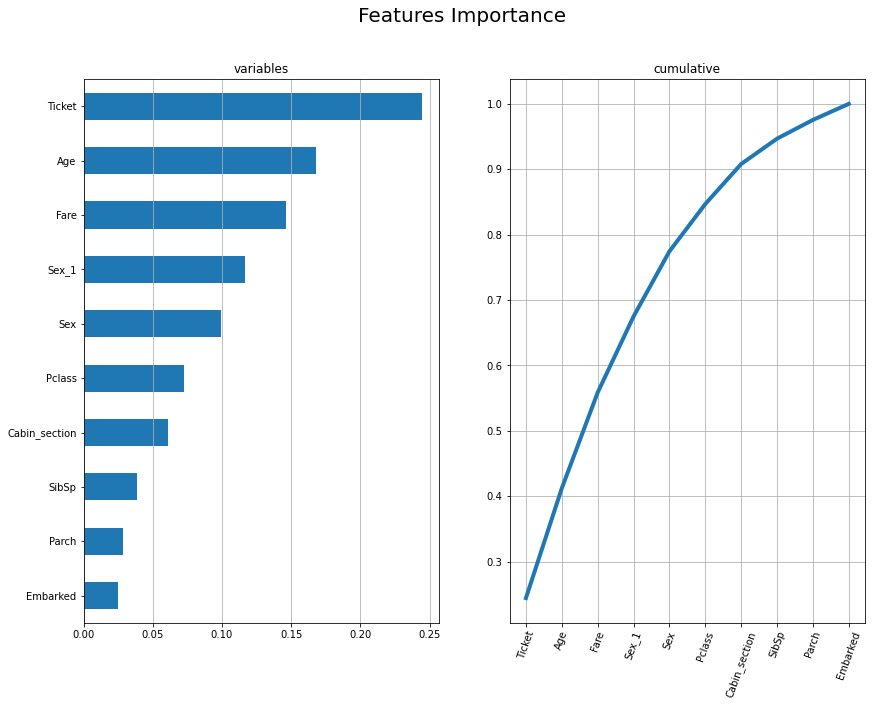

In [35]:
#Random forest is an ensemble method that consists of a number of decision trees in which every node is a condition 
#on a single feature, designed to split the dataset into two so that similar response values end up in the same set. 
#Features importance is computed from how much each feature decreases the entropy in a tree.


X = dtf_train.drop("Y", axis=1).values
y = dtf_train["Y"].values
feature_names = dtf_train.drop("Y", axis=1).columns.tolist()
## Importance
model = ensemble.RandomForestClassifier(n_estimators=100,criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_
## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False,figsize=(14,10))
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)), 
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

In [36]:
X_names = ["Age", "Fare", "Sex", "Pclass", "Parch","Cabin_section", "Embarked"]
X_train = dtf_train[X_names].values
y_train = dtf_train["Y"].values
X_test = dtf_test[X_names].values
y_test = dtf_test["Y"].values

In [37]:
## call model
model = ensemble.GradientBoostingClassifier()
## define hyperparameters combinations to try
param_dic = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],      #weighting factor for the corrections by new trees when added to the model
'n_estimators':[100,250,500,750,1000,1250,1500,1750],  #number of trees added to the model
'max_depth':[2,3,4,5,6,7],    #maximum depth of the tree
'min_samples_split':[2,4,6,8,10,20,40,60,100],    #sets the minimum number of samples to split
'min_samples_leaf':[1,3,5,7,9],     #the minimum number of samples to form a leaf
'max_features':[2,3,4,5,6,7],     #square root of features is usually a good starting point
'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}       #the fraction of samples to be used for fitting the individual base learners. Values lower than 1 generally lead to a reduction of variance and an increase in bias.
## random search
random_search = model_selection.RandomizedSearchCV(model, 
       param_distributions=param_dic, n_iter=1000, 
       scoring="accuracy").fit(X_train, y_train)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean accuracy:", random_search.best_score_)
model = random_search.best_estimator_

Best Model parameters: {'subsample': 0.8, 'n_estimators': 250, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 3, 'max_depth': 3, 'learning_rate': 0.01}
Best Model mean accuracy: 0.8314451612903225


<ipython-input-38-2d22aaebe46f>:10: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(scipy.interp(mean_fpr, fpr, tpr))
<ipython-input-38-2d22aaebe46f>:10: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(scipy.interp(mean_fpr, fpr, tpr))
<ipython-input-38-2d22aaebe46f>:10: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(scipy.interp(mean_fpr, fpr, tpr))
<ipython-input-38-2d22aaebe46f>:10: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(scipy.interp(mean_fpr, fpr, tpr))
<ipython-input-38-2d22aaebe46f>:10: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(scipy.interp(mean_fpr, fpr, tpr))
<ipython-input-38-2d22aaebe46f>:10: Depr

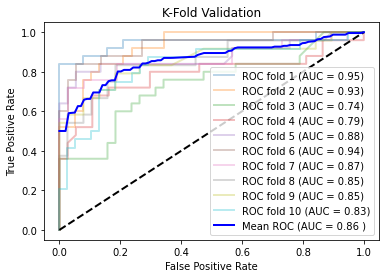

In [38]:
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True)
tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
   prediction = model.fit(X_train[train],
                y_train[train]).predict_proba(X_train[test])
   fpr, tpr, t = metrics.roc_curve(y_train[test], prediction[:, 1])
   tprs.append(scipy.interp(mean_fpr, fpr, tpr))
   roc_auc = metrics.auc(fpr, tpr)
   aucs.append(roc_auc)
   plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
   i = i+1
   
plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation')
plt.legend(loc="lower right")
plt.show()

In [39]:
## train
model.fit(X_train, y_train)

## test
predicted_prob = model.predict_proba(X_test)[:,1]
predicted = model.predict(X_test)

In [40]:
## Accuray e AUC
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob)
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))
    
## Precision e Recall
recall = metrics.recall_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted)
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in np.unique(y_test)]))

Accuracy (overall correct predictions): 0.83
Auc: 0.86
Recall (all 1s predicted right): 0.61
Precision (confidence when predicting a 1): 0.87
Detail:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       173
           1       0.87      0.61      0.72        95

    accuracy                           0.83       268
   macro avg       0.84      0.78      0.80       268
weighted avg       0.83      0.83      0.82       268



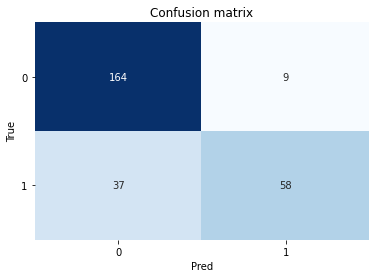

In [41]:
classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()